In [68]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# set matplotlib to default
plt.style.use('default')


In [2]:
DATASET_DIR = Path("data/")
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
SEED = 13


In [4]:

def load_image_df(data_split):
    """
    Load the image paths and labels into a DataFrame.
    Args:
        data_split (str): The data split to load (train, val, test). Loads from the corresponding directory.
    """
    image_paths = [] # list of paths to all the images
    labels = [] # associated labels for the images (NORMAL or PNEUMONIA)
    label_map = {"NORMAL": 0, "PNEUMONIA": 1} # mapping from class name to label


    index = 0
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(DATASET_DIR, data_split, class_name)
        
        file_names = os.listdir(class_dir)
        count = 0
        for file_name in file_names:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(class_dir, file_name)
                image_paths.append(image_path)
                labels.append(class_name)
               
                count += 1
                index += 1
        print(f"Found {count} images in {class_name} class for {data_split} set.")

    print(f"Total images in {data_split} set: {len(image_paths)} \n")

    df = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
    })
    df['encoded_label'] = df['label'].map(label_map)

    return df

In [14]:
test_data_df = load_image_df("test")
print(test_data_df.head())


Found 234 images in NORMAL class for test set.
Found 390 images in PNEUMONIA class for test set.
Total images in test set: 624 

                                     filepath   label  encoded_label
0          data/test/NORMAL/IM-0031-0001.jpeg  NORMAL              0
1          data/test/NORMAL/IM-0025-0001.jpeg  NORMAL              0
2  data/test/NORMAL/NORMAL2-IM-0272-0001.jpeg  NORMAL              0
3  data/test/NORMAL/NORMAL2-IM-0102-0001.jpeg  NORMAL              0
4  data/test/NORMAL/NORMAL2-IM-0229-0001.jpeg  NORMAL              0


In [28]:
# load file paths to attribution maps
ig_dir = Path("output/integrated_gradients/")
gradcam_dir = Path("output/gradcam_layer31/")



In [96]:
count = 0

[PosixPath('output/integrated_gradients/person150_bacteria_716_pred_1_prob_0.990_ig.jpeg')]
[PosixPath('output/integrated_gradients/person1655_virus_2861_pred_1_prob_0.950_ig.jpeg')]
[PosixPath('output/integrated_gradients/person154_bacteria_728_pred_0_prob_0.004_ig.jpeg')]
[PosixPath('output/integrated_gradients/person37_virus_82_pred_1_prob_0.991_ig.jpeg')]
[PosixPath('output/integrated_gradients/person124_bacteria_591_pred_1_prob_0.990_ig.jpeg')]


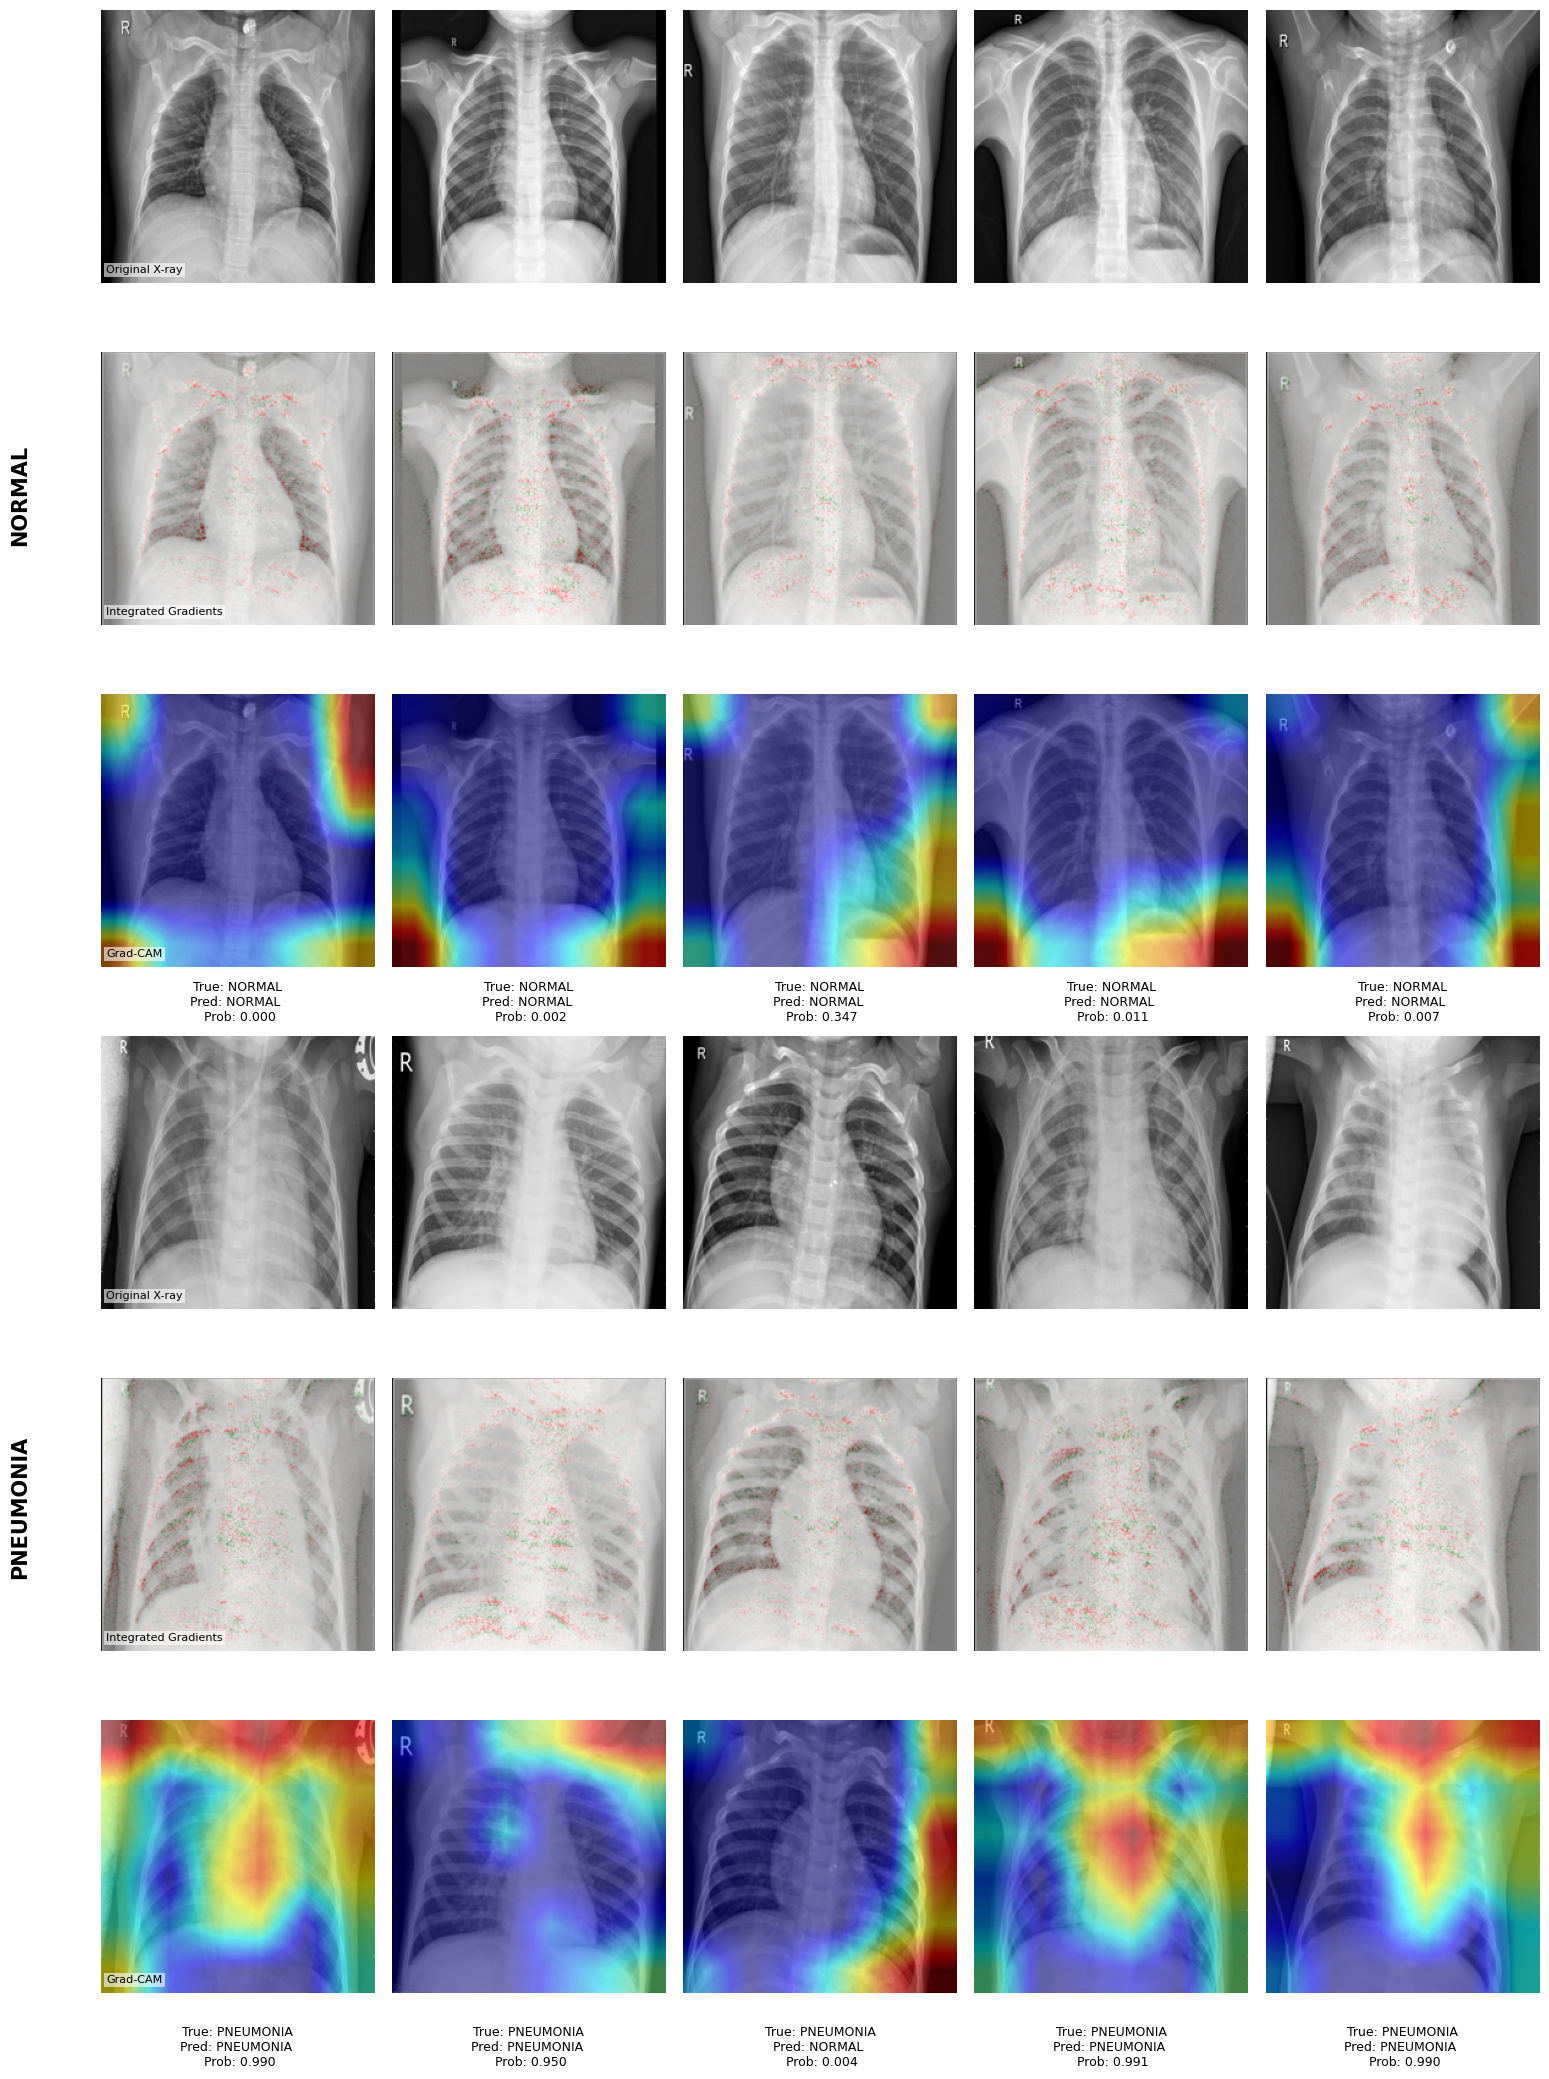

In [106]:

normal_df = test_data_df[test_data_df['label'] == 'NORMAL']
pneumonia_df = test_data_df[test_data_df['label'] == 'PNEUMONIA']
sample_normal_df = normal_df.sample(n=5, random_state=SEED)
sample_pneumonia_df = pneumonia_df.sample(n=5, random_state=SEED)

# Adjusted figsize for potentially portrait images. (Width, Height)
fig, ax = plt.subplots(6, 5, figsize=(16, 22)) 

def extract_prediction(ig_file_name, gc_file_name):
 
    """
    Extracts the probability value as a string from filenames.
    Looks for patterns like '_prob_VALUE'.
    Returns the VALUE (e.g., "0.098") as a string, or "N/A" if not found.
    """
    probability = "N/A"
    prediction = "N/A"


    filenames_to_check = []
    if ig_file_name:
        filenames_to_check.append(ig_file_name)
    if gc_file_name:
        filenames_to_check.append(gc_file_name)

    for filename in filenames_to_check:
        if not filename: # Skip if filename is None or empty
            continue

        # Regex to capture the probability value after '_prob_'
        # It captures floating point numbers (e.g., 0.098, 0.9, 1.0) or integers (e.g., 0, 1)
        # \d+ matches one or more digits.
        # (?:\.\d+)? matches an optional group: a literal dot followed by one or more digits.
        match_prob = re.search(r'_prob_(\d+(?:\.\d+)?)', filename, re.IGNORECASE)
        match_pred = re.search(r'_pred_(\d)', filename, re.IGNORECASE)
        if match_prob:
            probability = match_prob.group(1) # group(1) is the captured probability value
        
        if match_pred:
            prediction_str = match_pred.group(1)
            if prediction_str == "0":
                prediction = "NORMAL"
            elif prediction_str == "1":
                prediction = "PNEUMONIA"
            else:
                prediction = "N/A"

    return (prediction, float(probability))

row_type_texts = ["Original X-ray", "Integrated Gradients", "Grad-CAM"]

# --- Process and plot NORMAL samples ---
for i, row_tuple in enumerate(sample_normal_df.iterrows()):
    image_data = row_tuple[1]
    image_path = image_data['filepath']
    true_label = image_data['label']
    image_name = os.path.basename(image_path)

    original_pil_image = Image.open(image_path)
    original_image_resized = original_pil_image.resize((224, 224)) # Resize to match model input size

    ig_file_path_str, gradcam_file_path_str = None, None
    pattern_ig = image_name.replace('.jpeg', '_pred_*_prob_*.jpeg')
    ig_files = list(ig_dir.glob(pattern_ig))
    pil_ig_image, ig_image_resized = None, None
    if ig_files:
        ig_file_path_str = str(ig_files[0])
        pil_ig_image = Image.open(ig_file_path_str)
        pil_ig_image =pil_ig_image.crop((90, 70, 525, 500))
        ig_image_resized = pil_ig_image.resize((224, 224)) if ig_image else None

    pattern_gc = image_name.replace('.jpeg', '_pred_*.jpg')
    gradcam_files = list(gradcam_dir.glob(pattern_gc))
    pil_gradcam_image, gradcam_image_resized = None, None
    if gradcam_files:
        gradcam_file_path_str = str(gradcam_files[0])
        pil_gradcam_image = Image.open(gradcam_file_path_str)
        gradcam_image_resized = pil_gradcam_image.resize((224, 224)) 
    
    ax[0, i].imshow(original_image_resized, cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(ig_image_resized )
    ax[1, i].axis('off')
    ax[2, i].imshow(gradcam_image_resized )
    ax[2, i].axis('off')

    if i == 0: # Add row type text only to the first column's subplots
        for row_idx in range(3):
             ax[row_idx, 0].text(0.02, 0.03, row_type_texts[row_idx], transform=ax[row_idx, 0].transAxes,
                                 fontsize=8, color='black', ha='left', va='bottom',
                                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5))

    model_prediction,model_prob = extract_prediction(os.path.basename(ig_file_path_str) if ig_file_path_str else None, 
                                          os.path.basename(gradcam_file_path_str) if gradcam_file_path_str else None)
    model_prob = f'{model_prob:.3f}'

    text_to_display = f"True: {true_label}\nPred: {model_prediction} \n Prob: {model_prob}"
    ax[2, i].text(0.5, -0.05, text_to_display, ha='center', va='top', transform=ax[2, i].transAxes, fontsize=9) # Adjusted y offset


# --- Process and plot PNEUMONIA samples ---
for i, row_tuple in enumerate(sample_pneumonia_df.iterrows()):
    image_data = row_tuple[1]
    image_path = image_data['filepath']
    true_label = image_data['label']
    image_name = os.path.basename(image_path)

    original_pil_image = Image.open(image_path)
    original_image_resized = original_pil_image.resize((224, 224)) # Resize to match model input size

    ig_file_path_str, gradcam_file_path_str = None, None
    pattern_ig = image_name.replace('.jpeg', '_pred_*_prob_*.jpeg')
    ig_files = list(ig_dir.glob(pattern_ig))
    pil_ig_image, ig_image_resized = None, None
    if ig_files:
        ig_file_path_str = str(ig_files[0])
        pil_ig_image = Image.open(ig_file_path_str)
        pil_ig_image =pil_ig_image.crop((90, 70, 525, 500))
        ig_image_resized = pil_ig_image.resize((224, 224)) if ig_image else None

    print(ig_files)
    pattern_gc = image_name.replace('.jpeg', '_pred_*.jpg')
    gradcam_files = list(gradcam_dir.glob(pattern_gc))
    pil_gradcam_image, gradcam_image_resized = None, None
    if gradcam_files:
        gradcam_file_path_str = str(gradcam_files[0])
        pil_gradcam_image = Image.open(gradcam_file_path_str)
        gradcam_image_resized = pil_gradcam_image.resize((224, 224)) 

    ax[3, i].imshow(original_image_resized, cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(ig_image_resized)
    ax[4, i].axis('off')
    ax[5, i].imshow(gradcam_image_resized )
    ax[5, i].axis('off')
    
    if i == 0: # Add row type text only to the first column's subplots
        for row_idx_offset in range(3):
            current_row_abs = 3 + row_idx_offset
            ax[current_row_abs, 0].text(0.02, 0.03, row_type_texts[row_idx_offset], transform=ax[current_row_abs, 0].transAxes,
                                 fontsize=8, color='black', ha='left', va='bottom',
                                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5))

    model_prediction, model_prob = extract_prediction(os.path.basename(ig_file_path_str) if ig_file_path_str else None, 
                                          os.path.basename(gradcam_file_path_str) if gradcam_file_path_str else None)
    model_prob = f'{model_prob:.3f}'
    text_to_display = f"True: {true_label}\nPred: {model_prediction} \n Prob: {model_prob}"
    ax[5, i].text(0.5, -0.12, text_to_display, ha='center', va='top', transform=ax[5, i].transAxes, fontsize=9) # Adjusted y offset


# --- Layout Adjustments and Fig Text ---
fig_left_margin = 0.06 
fig_bottom_margin = 0.03
fig_right_margin = 0.98
fig_top_margin = 0.97

# Apply tight_layout first with the rect for margins
plt.tight_layout(rect=[fig_left_margin, fig_bottom_margin, fig_right_margin, fig_top_margin])

# Add "NORMAL" / "PNEUMONIA" fig.text using subplot positions (AFTER tight_layout)
# This ensures y-coordinates are based on the laid-out subplots
pos_norm_top = ax[0,0].get_position()
pos_norm_bottom = ax[2,0].get_position() # Bottom of the 3rd row in the NORMAL block
y_normal_group_center = (pos_norm_top.y1 + pos_norm_bottom.y0) / 2 # Midpoint in figure coords

pos_pneu_top = ax[3,0].get_position() # Top of the 1st row in the PNEUMONIA block
pos_pneu_bottom = ax[5,0].get_position()
y_pneumonia_group_center = (pos_pneu_top.y1 + pos_pneu_bottom.y0) / 2

# X-coordinate for "NORMAL"/"PNEUMONIA" text (in figure coords, left of fig_left_margin)
x_outer_label = 0.02 

fig.text(x_outer_label, y_normal_group_center, "NORMAL", 
         rotation=90, va='center', ha='center', fontsize=15, weight='bold')
fig.text(x_outer_label, y_pneumonia_group_center, "PNEUMONIA", 
         rotation=90, va='center', ha='center', fontsize=15, weight='bold')

# Fine-tune subplot spacing *after* tight_layout and placing fig.text
# hspace needs to accommodate the True/Pred text (y offset -0.12).
# A smaller y offset for True/Pred text means hspace can also be smaller.
fig.subplots_adjust(hspace=0.25, wspace=0.05) # Experiment with hspace

plt.show()
# Save the figure
output_dir = Path("output/attribution_maps/")
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / f"{count}_attribution_maps_with_prob.png"
count += 1
fig.savefig(output_path, bbox_inches='tight', dpi=300)

In [103]:
x = 0.02233
x = f'{x:.3f}'
print(x)

0.022
